In [1]:
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
import networkx as nx

In [2]:
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"

gdf = gpd.read_file(path)

print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']


In [3]:
# If CRS is geographic (lat/lon), reproject to EPSG: 2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
    print("Reprojected CRS: ", gdf.crs)

Reprojected CRS:  EPSG:2263


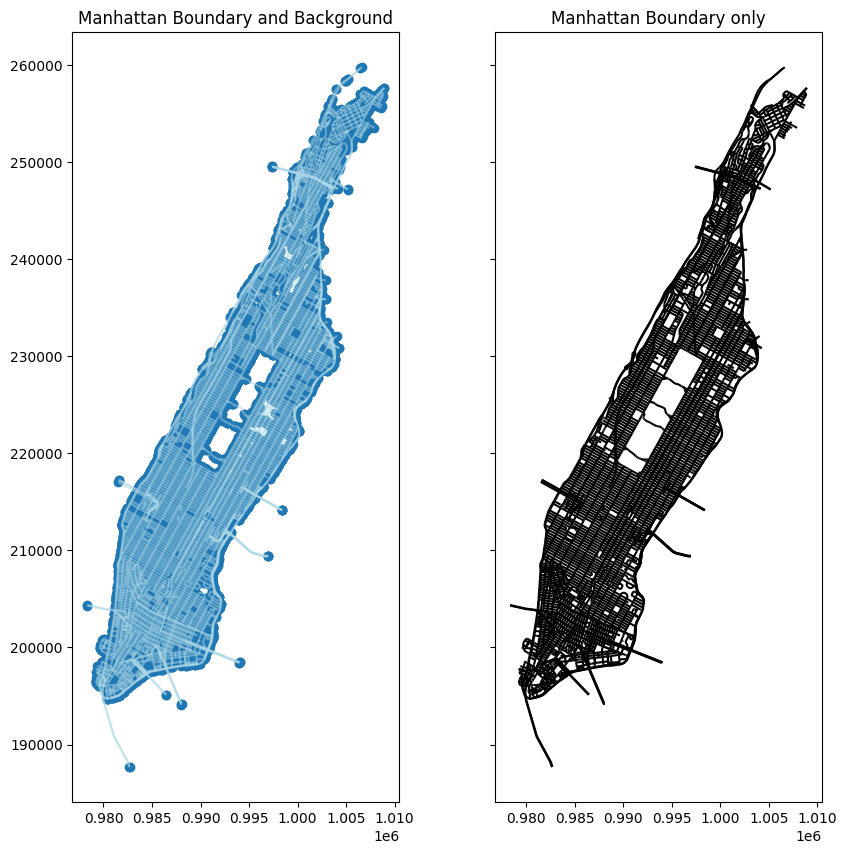

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
gdf.boundary.plot(ax=ax1, linewidth=1)
gdf.plot(ax=ax1, alpha=0.5, color="lightblue", edgecolor="black")
ax1.set_title("Manhattan Boundary and Background")

gdf.plot(ax=ax2, edgecolor="black", facecolor="none")
ax2.set_title("Manhattan Boundary only")

plt.show()


In [5]:
Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge
EdgeFlows = Dict[EdgeId, float]

@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float          # meters
    v_free: float            # free-flow speed (m/s)
    capacity: float          # max cars that fit on this segment
    alpha: float = 0.15
    beta: float = 4.0

    @property
    def free_time(self) -> float:
        # free-flow travel time (seconds)
        return self.length_m / self.v_free

    def travel_time(self, flow: float) -> float:
        # BPR-style congestion model
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]

@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


In [6]:
def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    # rounding keeps nodes consistent instead of having tiny float differences
    return round(x, ndigits), round(y, ndigits)

In [7]:
# --- Stochastic edge parameters ---

def sample_car_length() -> float:
    # lognormal with median around 4.5m
    mu = math.log(4.5)
    sigma = 0.15
    length = random.lognormvariate(mu, sigma)
    return max(length, 3.5)  # clamp to > 3.5m


def sample_gap() -> float:
    # lognormal with median around 1.5m
    mu = math.log(1.5)
    sigma = 0.25
    gap = random.lognormvariate(mu, sigma)
    return max(gap, 0.5)


def sample_spacing() -> float:
    # space per vehicle = car length + gap
    return sample_car_length() + sample_gap()


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    This gives a fatter tail toward low speeds.
    """
    median_s_per_m = 0.09  # ~40 km/h
    mu = math.log(median_s_per_m)
    sigma = 0.3            # spread; larger => more slow edges

    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m                      # m/s

    # clamp speeds to a plausible urban range ~ 18–90 km/h
    v_free = max(min(v_free, 25.0), 5.0)
    return v_free

In [8]:
def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> TrafficNetwork:
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for idx, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                # stochastic capacity & free-flow speed
                spacing = sample_spacing()                # m per car
                capacity = max(length_m / spacing, 1.0)   # cars
                v_free = sample_free_speed_time_based()   # m/s

                # directed u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(
                        start=u,
                        end=v,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[u].append(e1)

                # bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(
                        start=v,
                        end=u,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)

### Build the graph

In [9]:
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")

# nodes: 37086
# edges: 81228


### Convert to NetworkX

# NX nodes: 37086 # NX edges: 81228


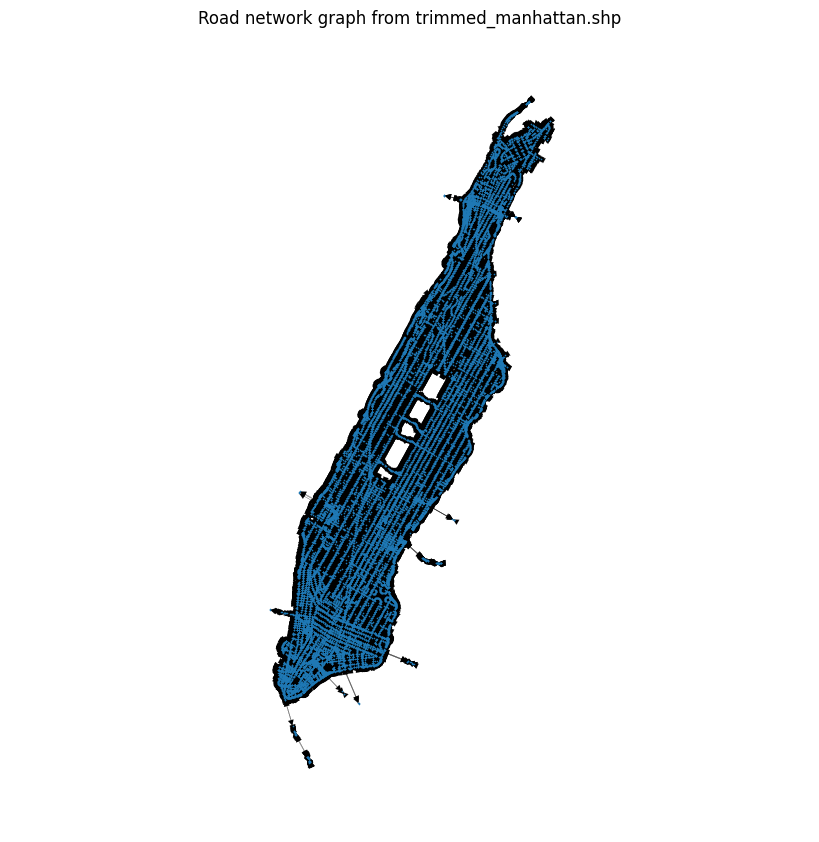

In [10]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G

G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

### Agents + OD selection

In [11]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None

### Random selection

In [12]:
def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

### North to South Commute

In [13]:
def sample_agents_north_south(network: TrafficNetwork,
                               num_agents: int,
                               band_split: float = 0.5) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]

    assert north_nodes and south_nodes, "North/south bands are empty – check CRS or band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

In [14]:
def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = 10% top band, south = 10% bottom band
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d

In [15]:
def sample_agents_fixed(network: TrafficNetwork,
                        num_agents: int,
                        origin: Node,
                        destination: Node) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]

### Dijkstra on TrafficNetwork

In [16]:
import heapq

def dijkstra(network: TrafficNetwork,
             source: Node,
             target: Node,
             edge_flows: EdgeFlows) -> List[Node]:
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)

        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])  # cost depends on current flow
            nd = d + w

            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path

In [102]:
def dijkstra_marginal_cost(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows,
    lambda_time: float = 1.0
) -> List[Node]:
    """
    Ford–Fulkerson style routing, but with a constraint that ensures
    agents prefer shorter physical routes:

    weight = marginal_cost + lambda_time * free_flow_time
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)

        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            # Enforce capacity
            if edge_flows[edge_id] >= edge.capacity:
                continue

            # Marginal COIN term
            f_before = edge_flows[edge_id]
            marginal = edge_marginal_cost(edge, f_before)

            # Time constraint term
            t = edge.free_time

            # Combined cost
            new_cost = cost_u + marginal + lambda_time * t

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []

    # Reconstruct path
    path = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path

### Utility function: get edges from a path

In [17]:
def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))

### SPA routing: selfish, sequential assignment

In [18]:
def spa_route_all(network: TrafficNetwork,
                  agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    edge_flows: EdgeFlows = defaultdict(float)

    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path

        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent

    return agents, edge_flows

In [95]:
def coin_ff_route_all(network: TrafficNetwork,
                      agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """
    Ford–Fulkerson–style COIN:
    - For each agent, find an augmenting path that minimizes marginal
      increase in global cost G (using dijkstra_marginal_cost).
    - Push 1 unit of flow along that path.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    for agent in agents:
        path = dijkstra_marginal_cost(
            network,
            agent.origin,
            agent.destination,
            edge_flows
        )
        agent.path = path

        for e in edges_from_path(path):
            edge_flows[e] += 1.0

    return agents, edge_flows

### World Utility

In [96]:
def total_system_travel_time(network: TrafficNetwork,
                             edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total

# Fixed OD pair and SPA shortest path (for reward shaping)

In [97]:
origin, destination = pick_north_south_pair(manhattan_network)

zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))

Origin: (1001330.319, 245480.925)
Destination: (986892.247, 201345.581)
Shortest path length (edges): 750


In [98]:
def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

In [99]:
def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in global G if one more car uses it?
    """
    f1 = flow_before
    f2 = flow_before + 1

    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)

    G1 = f1 * t1
    G2 = f2 * t2

    return G2 - G1

# COIN / RL helpers

In [22]:
def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]

In [23]:
def choose_action_eps_greedy(network: TrafficNetwork,
                             Q: Dict[Tuple[Node, Node, Node], float],
                             state_node: Node,
                             dest_node: Node,
                             epsilon: float) -> Node:
    neighbors = get_neighbors(network, state_node)
    if not neighbors:
        return state_node  # dead end, stay put (will break later)

    # exploration
    if random.random() < epsilon:
        return random.choice(neighbors)

    # exploitation: pick neighbor with highest Q
    best_q = None
    best_actions = []
    for a in neighbors:
        key = (state_node, dest_node, a)
        q = Q.get(key, 0.0)
        if best_q is None or q > best_q:
            best_q = q
            best_actions = [a]
        elif q == best_q:
            best_actions.append(a)

    return random.choice(best_actions)

# COIN-RL with shaped rewards and fixed OD

In [38]:
def train_coin_rl(
    network: TrafficNetwork,
    episodes: int = 200,
    num_agents: int = 100,
    od_mode: str = "fixed",   # ignored internally, we use fixed OD
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon_start: float = 0.9,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 400
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    COIN-style Q-learning with shaped rewards and a fixed origin/destination.

    Uses the globally defined `origin`, `destination`, and `shortest_edges`.

    Reward combines:
      - small penalty for marginal congestion,
      - strong reward for progress toward destination,
      - small penalty for using SPA-shortest-path edges,
      - large terminal reward for reaching destination,
      - small step penalty to discourage wandering.
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    # reward weights (tuned to prioritise reaching dest + progress)
    lambda_cong = 0.01   # very small congestion weight
    lambda_prog = 2.0    # strong incentive to move toward destination
    lambda_sp   = 0.05   # soft penalty for using SPA edges
    step_penalty = 0.2   # cost per move
    terminal_bonus = 5000.0

    for ep in range(episodes):
        # Linear epsilon decay
        epsilon = epsilon_start + (epsilon_end - epsilon_start) * (
            ep / max(1, episodes - 1)
        )

        # All agents share the same fixed OD pair
        agents = sample_agents_fixed(network, num_agents, origin, destination)

        for agent in agents:
            s = agent.origin
            d = agent.destination
            steps = 0

            while s != d and steps < max_steps_per_agent:
                neighbors = get_neighbors(network, s)
                if not neighbors:
                    break  # dead end

                a = choose_action_eps_greedy(network, Q, s, d, epsilon)
                edge_id = (s, a)
                if edge_id not in network.edges:
                    break

                edge = network.edges[edge_id]

                # 1) small congestion term (at free-flow)
                f_before = 0.0
                delta_G = edge_marginal_cost(edge, f_before)

                # 2) progress term
                old_dist = dist_to_dest(s, d)
                new_dist = dist_to_dest(a, d)
                progress = old_dist - new_dist  # positive if closer

                # 3) SPA-edge penalty
                on_spa_shortest = 1.0 if edge_id in shortest_edges else 0.0

                # Base shaped reward
                reward = (
                    -step_penalty
                    - lambda_cong * delta_G
                    + lambda_prog * progress
                    - lambda_sp * on_spa_shortest
                )

                # 4) big bonus if we *arrive* with this action
                if a == d:
                    reward += terminal_bonus

                # Next state
                s_next = a

                # Q-learning update
                key = (s, d, a)
                old_q = Q.get(key, 0.0)

                next_neighbors = get_neighbors(network, s_next)
                if next_neighbors:
                    max_next_q = max(
                        Q.get((s_next, d, a_next), 0.0)
                        for a_next in next_neighbors
                    )
                else:
                    max_next_q = 0.0

                target = reward + gamma * max_next_q
                Q[key] = old_q + alpha * (target - old_q)

                # move
                s = s_next
                steps += 1

        print(f"Episode {ep+1}/{episodes} finished, epsilon={epsilon:.3f}")

    return Q

In [25]:
def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents and computing the resulting edge flows and G.
    By default uses the fixed global (origin, destination); if od_mode == "north_south"
    you can still sample north-south commuters instead.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode == "north_south":
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed" or anything else -> use fixed OD
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            # greedy: epsilon = 0
            best_q = None
            best_actions = []
            for a in neighbors:
                key = (s, d, a)
                q = Q.get(key, 0.0)
                if best_q is None or q > best_q:
                    best_q = q
                    best_actions = [a]
                elif q == best_q:
                    best_actions.append(a)

            a = random.choice(best_actions)

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

# Experiment wrappers

## SPA Experiment

In [85]:
def run_spa_experiment(network: TrafficNetwork,
                       num_agents: int = 500,
                       od_mode: str = "north_south") -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")

    return agents, edge_flows, G

## RL Coin Experiment

In [89]:
def run_coin_experiment_rl(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed",
    episodes: int = 200,
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon_start: float = 0.9,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 1500,
    seed: Optional[int] = 42
) -> Tuple[Dict[Tuple[Node, Node, Node], float], List[Agent], EdgeFlows, float]:
    """
    Train a COIN-style RL policy and evaluate it on a fresh set of agents.
    Returns: Q, agents_coin, edge_flows_coin, G_coin
    """
    if seed is not None:
        random.seed(seed)

    print("=== Training COIN-RL policy ===")
    Q = train_coin_rl(
        network=network,
        episodes=episodes,
        num_agents=num_agents,
        od_mode=od_mode,
        alpha=alpha,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        max_steps_per_agent=max_steps_per_agent,
    )

    print("\n=== Evaluating COIN-RL policy ===")
    agents_coin, edge_flows_coin, G_coin = route_with_trained_Q(
        network=network,
        Q=Q,
        num_agents=num_agents,
        od_mode=od_mode,
        max_steps_per_agent=max_steps_per_agent,
    )

    print(f"COIN-RL experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_COIN_RL: {G_coin:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows_coin.items() if f > 0])} / {len(network.edges)}")

    return Q, agents_coin, edge_flows_coin, G_coin

## Coin FF Experiment

In [105]:
def run_coin_ff_experiment(network,
                           num_agents: int = 500,
                           od_mode: str = "fixed"):
    """
    Ford–Fulkerson style COIN experiment:
    routes agents using coin_ff_route_all and computes world utility G.
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_flows = coin_ff_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"COIN-FF experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_COIN_FF: {G:.2f}")
    print(f"Used edges: {len([e for e,f in edge_flows.items() if f > 0])} / {len(network.edges)}")

    return agents, edge_flows, G

In [106]:
# === COIN-FF → Expert Dataset for Imitation Learning =====================

from collections import defaultdict

def build_coin_ff_expert_dataset(
    network: TrafficNetwork,
    num_agents: int = 200,
    od_mode: str = "fixed"
):
    """
    Run COIN-FF once and record (state, dest, action) triples
    from the COIN-FF paths. This is our 'expert' dataset.

    We ONLY keep steps from agents that actually reach their destination,
    to avoid teaching RL to wander or get stuck.
    """
    # Sample agents according to od_mode
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    # Route them with COIN-FF (this updates edge_flows internally)
    agents_ff, edge_flows_ff = coin_ff_route_all(network, agents)

    expert_triples = []  # list of (state_node, dest_node, action_node)

    for agent in agents_ff:
        # keep only successful trajectories
        if not agent.path or agent.path[-1] != agent.destination:
            continue
        d = agent.destination
        for (s, a) in edges_from_path(agent.path):
            expert_triples.append((s, d, a))

    print(f"Collected {len(expert_triples)} expert (s,d,a) triples "
          f"from {len(agents_ff)} COIN-FF agents.")
    return expert_triples

In [107]:
# === Train Q from COIN-FF expert (Behavior Cloning) ======================

from typing import Dict, Tuple

def train_q_from_coin_ff_expert(
    expert_triples,
    alpha_bc: float = 0.5
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    Simple behavior-cloning style 'RL':
    For each expert (s, d, a) triple we push Q(s,d,a) toward 1.0.

    Later, route_with_trained_Q will act greedily wrt Q and
    (ideally) reproduce COIN-FF decisions.
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    for (s, d, a) in expert_triples:
        key = (s, d, a)
        old_q = Q.get(key, 0.0)
        target = 1.0                # "expert" value
        Q[key] = old_q + alpha_bc * (target - old_q)

    print(f"Trained Q on {len(expert_triples)} expert steps "
          f"(unique state-action pairs: {len(Q)}).")
    return Q

## Imitation of LL Experiment

In [108]:
# === Experiment: SPA vs COIN-FF vs COIN-RL(BC) ===========================

def run_coin_rl_from_expert_experiment(
    network: TrafficNetwork,
    num_agents_spa: int = 100,
    num_agents_expert: int = 200,
    num_agents_eval_rl: int = 100,
    od_mode: str = "fixed"
):
    """
    1) SPA baseline
    2) COIN-FF expert (used only to generate dataset)
    3) COIN-RL(BC): Q-policy trained to imitate COIN-FF,
       then evaluated on fresh agents with route_with_trained_Q.
    """

    # --- 1) SPA baseline ---
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_spa,
        od_mode=od_mode
    )

    # --- 2) COIN-FF expert dataset ---
    expert_triples = build_coin_ff_expert_dataset(
        network,
        num_agents=num_agents_expert,
        od_mode=od_mode
    )
    Q_rl = train_q_from_coin_ff_expert(expert_triples, alpha_bc=0.5)

    # --- 3) Evaluate RL policy learned from expert ---
    agents_rl, flows_rl, G_rl = route_with_trained_Q(
        network=network,
        Q=Q_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=1500   # reuse your previous limit
    )

    print("\n=== Summary: SPA vs COIN-RL(BC) ===")
    print(f"G_SPA      = {G_spa:.2f}")
    print(f"G_RL(BC)   = {G_rl:.2f}")
    print(f"Improvement (RL vs SPA) = {(G_spa - G_rl) / G_spa * 100:.2f}%")

    return (agents_spa, flows_spa, G_spa,
            agents_rl,  flows_rl,  G_rl,
            Q_rl)

# Run main experiments

In [91]:
def fraction_reached(agents, dest):
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)

## SPA vs Coin

In [92]:
random.seed(42)

num_agents = 10

# SPA baseline (fixed OD so it's comparable to COIN-RL)
agents_spa, flows_spa, G_spa = run_spa_experiment(
    manhattan_network,
    num_agents=num_agents,
    od_mode="fixed"
)

# Train + evaluate COIN-RL
Q, agents_coin, flows_coin, G_coin = run_coin_experiment_rl(
    manhattan_network,
    num_agents=num_agents,
    od_mode="fixed",
    episodes=200
)

print(f"\nG_SPA      = {G_spa:.2f}")
print(f"G_COIN_RL  = {G_coin:.2f}")
print(f"Improvement = {(G_spa - G_coin) / G_spa * 100:.2f}%")
print("\n")
print("SPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN fraction reaching dest:", fraction_reached(agents_coin, destination))

SPA experiment with 10 agents (fixed O/D)
Total system travel time G: 60029.15
Used edges: 3169 / 81228
=== Training COIN-RL policy ===
Episode 1/200 finished, epsilon=0.900
Episode 2/200 finished, epsilon=0.896
Episode 3/200 finished, epsilon=0.891
Episode 4/200 finished, epsilon=0.887
Episode 5/200 finished, epsilon=0.883
Episode 6/200 finished, epsilon=0.879
Episode 7/200 finished, epsilon=0.874
Episode 8/200 finished, epsilon=0.870
Episode 9/200 finished, epsilon=0.866
Episode 10/200 finished, epsilon=0.862
Episode 11/200 finished, epsilon=0.857
Episode 12/200 finished, epsilon=0.853
Episode 13/200 finished, epsilon=0.849
Episode 14/200 finished, epsilon=0.844
Episode 15/200 finished, epsilon=0.840
Episode 16/200 finished, epsilon=0.836
Episode 17/200 finished, epsilon=0.832
Episode 18/200 finished, epsilon=0.827
Episode 19/200 finished, epsilon=0.823
Episode 20/200 finished, epsilon=0.819
Episode 21/200 finished, epsilon=0.815
Episode 22/200 finished, epsilon=0.810
Episode 23/200 

In [109]:
random.seed(42)

num_agents = 10  # or 100, whatever you prefer

# SPA baseline (fixed OD so it's comparable)
agents_spa, flows_spa, G_spa = run_spa_experiment(
    manhattan_network,
    num_agents=num_agents,
    od_mode="fixed"
)

# COIN baseline using Ford–Fulkerson-style marginal-cost routing
agents_coin, flows_coin, G_coin = run_coin_ff_experiment(
    manhattan_network,
    num_agents=num_agents,
    od_mode="fixed"
)

print(f"\nG_SPA      = {G_spa:.2f}")
print(f"G_COIN_FF  = {G_coin:.2f}")
print(f"Improvement = {(G_spa - G_coin) / G_spa * 100:.2f}%")
print("\n")
print("SPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN fraction reaching dest:", fraction_reached(agents_coin, destination))

SPA experiment with 10 agents (fixed O/D)
Total system travel time G: 47634.17
Used edges: 2640 / 81228
COIN-FF experiment with 10 agents (fixed O/D)
Total system travel time G_COIN_FF: 46443.02
Used edges: 4236 / 81228

G_SPA      = 47634.17
G_COIN_FF  = 46443.02
Improvement = 2.50%


SPA fraction reaching dest: 1.0
COIN fraction reaching dest: 1.0


In [110]:
random.seed(42)

(agents_spa, flows_spa, G_spa,
 agents_rl,  flows_rl,  G_rl,
 Q_rl) = run_coin_rl_from_expert_experiment(
    manhattan_network,
    num_agents_spa=100,
    num_agents_expert=200,
    num_agents_eval_rl=100,
    od_mode="fixed"   # same OD as your COIN-FF
)

# Fraction of agents that actually reach destination
def fraction_reached(agents, dest):
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)

print("\nSPA fraction reaching dest: ",
      fraction_reached(agents_spa, destination))
print("RL(BC) fraction reaching dest: ",
      fraction_reached(agents_rl, destination))

SPA experiment with 100 agents (fixed O/D)
Total system travel time G: 873628.59
Used edges: 16596 / 81228
Collected 10910 expert (s,d,a) triples from 200 COIN-FF agents.
Trained Q on 10910 expert steps (unique state-action pairs: 5820).

=== Summary: SPA vs COIN-RL(BC) ===
G_SPA      = 873628.59
G_RL(BC)   = 5092185285.65
Improvement (RL vs SPA) = -582777.59%

SPA fraction reaching dest:  1.0
RL(BC) fraction reaching dest:  1.0


# Per-agent travel times

In [63]:
def compute_agent_travel_times(network: TrafficNetwork,
                               edge_flows: EdgeFlows,
                               agents: List[Agent]) -> List[float]:
    times = []
    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue
        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            flow = edge_flows[(u, v)]
            total += edge.travel_time(flow)
        times.append(total)
    return times

spa_times = compute_agent_travel_times(manhattan_network, flows_spa, agents_spa)
coin_times = compute_agent_travel_times(manhattan_network, flows_coin, agents_coin)

print("SPA avg time:", sum(spa_times) / len(spa_times))
print("COIN-RL avg time:", sum(coin_times) / len(coin_times))

1000
1000
SPA avg time: 16325528739.84716
COIN-RL avg time: 474999442859.6091


# Visualization helpers

In [59]:
def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)

def edge_flows_to_gdf(edge_flows: EdgeFlows,
                      network: TrafficNetwork,
                      crs) -> gpd.GeoDataFrame:
    geoms = []
    flows = []
    for (u, v), f in edge_flows.items():
        if f <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(f)
    return gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)

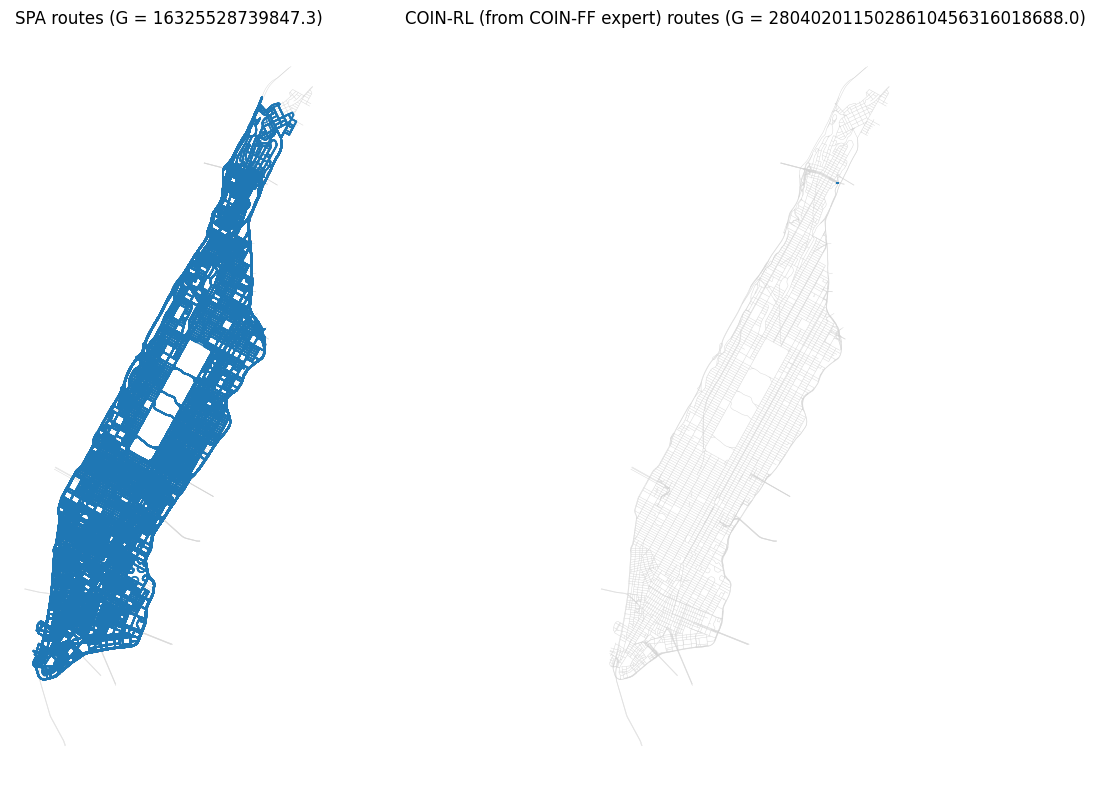

In [83]:
routes_spa  = routes_to_gdf(agents_spa, crs=gdf.crs)
routes_rl   = routes_to_gdf(agents_rl,  crs=gdf.crs)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
axes[0].set_axis_off()

gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
routes_rl.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
axes[1].set_title(f"COIN-RL (from COIN-FF expert) routes (G = {G_rl:.1f})")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# SPA vs Coin routes

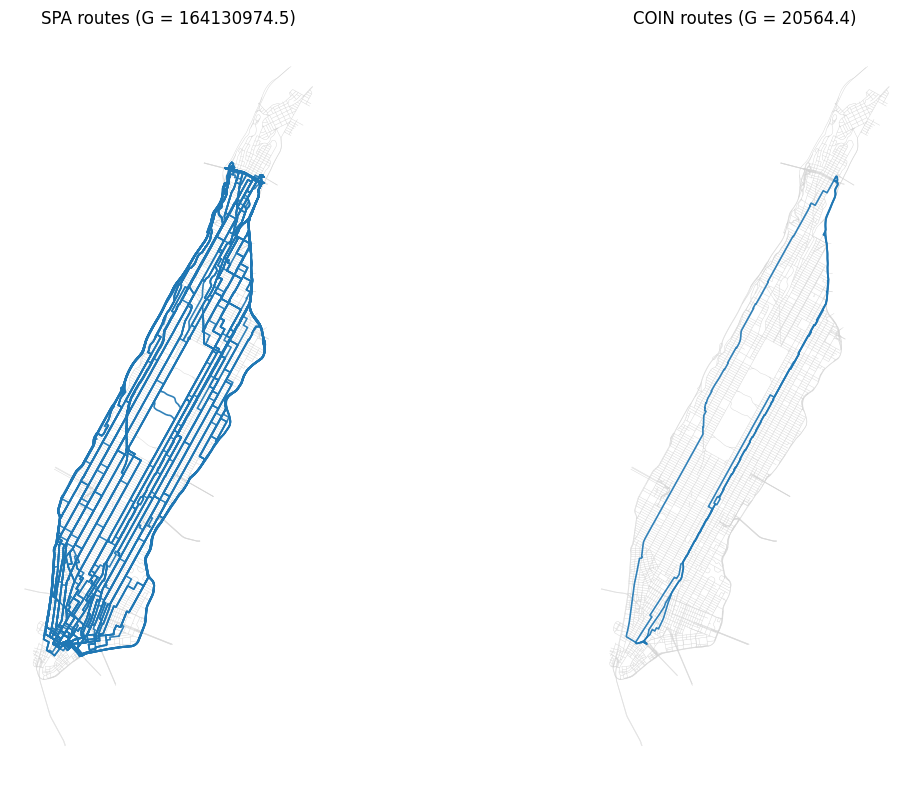

In [55]:
routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
routes_coin = routes_to_gdf(agents_coin, crs=gdf.crs)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# SPA routes
gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
axes[0].set_axis_off()

# COIN routes
gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
routes_coin.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
axes[1].set_title(f"COIN routes (G = {G_coin:.1f})")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# SPA vs COIN heatmaps

In [ ]:
flows_spa_gdf = edge_flows_to_gdf(flows_spa, manhattan_network, crs=gdf.crs)
flows_coin_gdf = edge_flows_to_gdf(flows_coin, manhattan_network, crs=gdf.crs)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
flows_spa_gdf.plot(
    ax=axes[0],
    column="flow",
    linewidth=2,
    alpha=0.9,
    legend=True
)
axes[0].set_title("SPA edge flows")
axes[0].set_axis_off()

# COIN heatmap
gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
flows_coin_gdf.plot(
    ax=axes[1],
    column="flow",
    linewidth=2,
    alpha=0.9,
    legend=True
)
axes[1].set_title("COIN edge flows")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()